# MIT JLab Project: Detect GW with LIGO open data
Author: Jing Wang <br>
Date: Sep 29 2020

* This tutorial is developed for MIT Junior lab project "Detect GW with LIGO open data".
* A manual of this project can be found [here](http://www.mit.edu/~jwang011/LIGOmanualJLab.pdf).
* This tutorial is based on the material on [Gravitational Wave Open Science Center](https://www.gw-openscience.org/) and the tutorial from Professor Philip Harris.
* Some codes are hidden, and you need to build it by yourself.
* <span style="color:#CF7A17;font-weight:bold">Orange bold text</span> hightlights the questions you need to answer or codes you need to develop.

## Introduction
The existence of gravitational waves (GW) was first predicted by Albert Einstein in his General Theory of Relativity in 1916.
He found that the linearized weak-field equations had wave solutions.
By analogy to electromagnetism, time variation of the mass quadrupole moment of the source is expected to lead to transverse waves of spatial strain.
The existence of GW was first demonstrated in 1974 by the discovery of a binary system composed of a pulsar in orbit around a neutron star by Hulse and Taylor [[1]](https://ui.adsabs.harvard.edu/abs/1975ApJ...195L..51H/abstract).
However, direct detections of GW did not arrive until 2016.
In that year, The LIGO (The Laser Interferometer Gravitational-Wave Observatory) collaboration reported the first direct detection of GW from a binary black hole system merging to form a single black hole [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102).
The observations reported in this paper and futher GW detections would provide new tests of generay relativity in its strong-field regime, and GW observations have become an important new means to learn about the Universe.

In this project, you will reproduce the results reported in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102) with LIGO open data. This tutorial will show how to analyze a particular GW event GW150914. In the tutorial, you will find how to download the data collected by Handford Observatory starting from Mon Sep 14 09:16:37 GMT 2015, plot the strain, whiten and filter the strain, plot a q-transform of the data, and extract the features of the source with a simple analytic model. After getting familiar with the basic analysis methods, you need to explore more events, check the consistence between detectors, match numerical relativity waveform template to extract accurate information of the source, compare with LIGO published results, and develop a machinery to search GW event within a long time range.

## Preparation

### Download the data

    wget -P data https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5

All the available open data can be found on [Gravitational Wave Open Science Center](https://www.gw-openscience.org/eventapi/html/allevents/). In this tutorial, we take event GW150914 data as example. In the name of this particular data file:
  * "GW150914" means September 14, 2015 
  * "H-H1" means that the data come from the LIGO Hanford Observatory site and the LIGO "H1" datector;
  * "1126257414-4096" means the data starts at GPS time 1126257414 (Mon Sep 14 09:16:37 GMT 2015), duration 4096 seconds;
    * NOTE: GPS time is number of seconds since Jan 6, 1980 GMT. See http://www.oc.nps.edu/oc2902w/gps/timsys.html.

### Load libraries

In [1]:
#----------------------------------------------------------------
# Load libraries
#----------------------------------------------------------------
import numpy as np
import math
from gwpy.timeseries import TimeSeries

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

import os

%matplotlib inline

### Set input file and parameters

In [2]:
#----------------------------------------------------------------
# Set parameters
#----------------------------------------------------------------
fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5' # data file
tevent = 1126259462.422 # Mon Sep 14 09:50:45 GMT 2015
evtname = 'GW150914' # event name

detector = 'H1' # detecotr: L1 or H1

### Load data

In [3]:
#----------------------------------------------------------------
# Load LIGO data
#----------------------------------------------------------------
strain = TimeSeries.read(fn, format='hdf5.losc')
center = int(tevent)
strain = strain.crop(center-16, center+16)

## Analysis on a known event

### First look at data: raw time-series data

<Figure size 432x288 with 0 Axes>

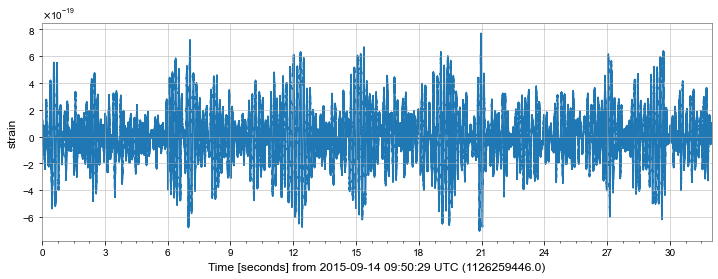

In [4]:
#----------------------------------------------------------------
# Show LIGO strain vs. time
#----------------------------------------------------------------
plt.figure()
strain.plot()
plt.ylabel('strain')
plt.show()

The data are dominated by low frequency noise, and there is no way to see a signal here.

### Data in the Fourier domain: ASDs

Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD. The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data. They are an estimate of the "strain-equivalent noise" of the detectors versus frequency, which limit the ability of the detectors to identify GW signals.

<Figure size 432x288 with 0 Axes>

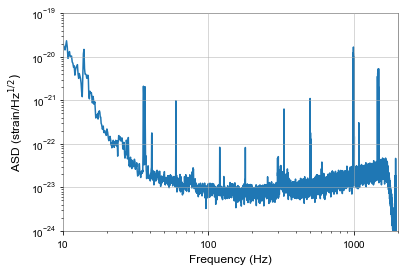

In [5]:
#----------------------------------------------------------------
# Obtain the power spectrum density PSD / ASD
#----------------------------------------------------------------

asd = strain.asd(fftlength=8)

plt.clf()
asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

You can see strong spectral lines in the data. They are all of instrumental origin. Some are engineered into the detectors (mirror suspension resonances at ~500 Hz and harmonics, calibration lines, control dither lines, etc) and some (60 Hz and harmonics) are unwanted. We'll return to these, later.

You can't see the signal in this plot, since it is relatively weak and less than a second long, while this plot averages over 32 seconds of data. So this plot is entirely dominated by instrumental noise.

### Whitening data
From the ASD above, we can see that noise fluctuations are much larger at low and high frequencies and near spectral lines. We can "whiten" the data, suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band.

<Figure size 432x288 with 0 Axes>

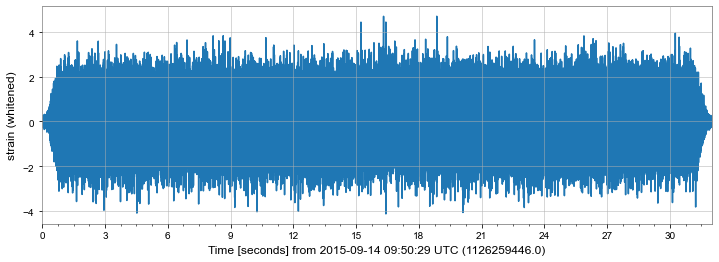

In [6]:
#----------------------------------------------------------------
# Whitening data
#----------------------------------------------------------------

white_data = strain.whiten()

plt.clf()
white_data.plot()
plt.ylabel('strain (whitened)')
plt.show()

We seem to see potential signal now... (maybe?) It's still not good enought, next we will apply a band-pass filter to reject high frequency noise.

### Bandpassing filter
The macro below shows you a framework to do bandpanssing.<br>
<span style="color:#CF7A17;font-weight:bold">What you need to do: play with the filter thresholds (bandpass_low and bandpass_high), and find a window leading to a clear signal.</span>

In [7]:
print('# [Hidden code] Here set:\nbandpass_low =\nbandpass_high =\n')
bandpass_low = 30
bandpass_high = 400

# [Hidden code] Here set:
bandpass_low =
bandpass_high =



<Figure size 432x288 with 0 Axes>

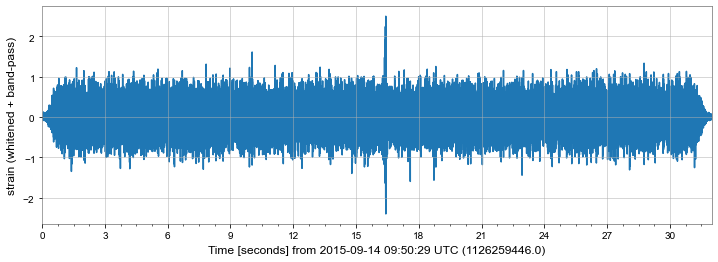

In [8]:
#----------------------------------------------------------------
# Bandpass filtering
#----------------------------------------------------------------

white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)

plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.show()

With the proper bandpass_low and bandpass_high set, we see a significant signal! Next let's zoom in it.

<Figure size 432x288 with 0 Axes>

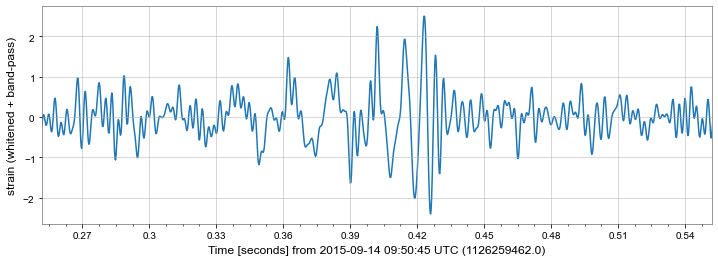

In [9]:
plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.xlim(tevent-0.17, tevent+0.13)
plt.show()

We see wave shape!! Yap this is GW signal.

### Plot a q-transform of the data
Next we take a q-transform of the data and check the time variation of frequency.

C:\Users\mszurek\anaconda3\envs\LIGO\lib\site-packages\gwpy\plot\plot.py:395: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = super().colorbar(mappable, **kwargs)


<Figure size 432x288 with 0 Axes>

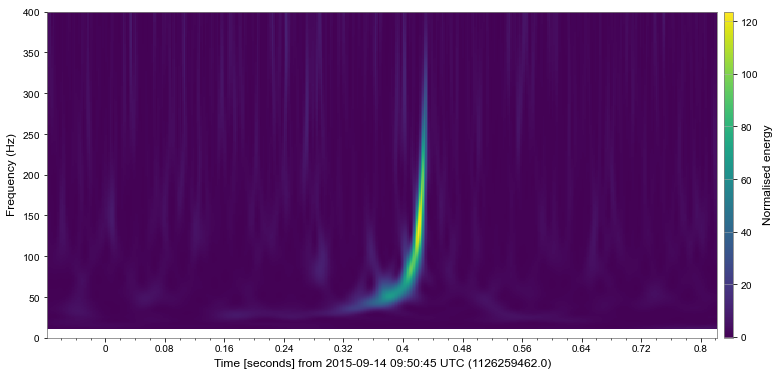

In [10]:
#----------------------------------------------------------------
# q-transform
#----------------------------------------------------------------

dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))

plt.clf()
fig = hq.plot()
ax = fig.gca()
fig.colorbar(label="Normalised energy")
ax.grid(False)
plt.xlim(tevent-0.5, tevent+0.4)
plt.ylim(0, 400)
plt.ylabel('Frequency (Hz)')
plt.show()

The yellow line is signal. Next we try developing an analytic model to describe this.

In [11]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

### Analytic model: frequency vs. time
Calculating the actual waveform requires complicated numerical simulations. However, we can use the basic knowledge of General Relativity (GR) and Newtonian mechanics to perform an approximate analytic calculation for the waveform. For an orbiting binary system ($m_{1}$ and $m_{2}$), according to GR the frequency ($\omega(t)$) of the GW radiation satisfies
\begin{equation}
\dot{\omega} = \frac{12}{5}2^{\frac{1}{3}}\left(\frac{G\mathcal{M}_{c}}{c^{3}}\right)^{\frac{5}{3}}\omega^{\frac{11}{3}}
\label{eq:wwdot}
\end{equation}
where $G$ and $c$ are gravitational constant and the speed of light respectively. $\mathcal{M}_{c}$ is so-called chirp mass, defined by
\begin{equation}
\mathcal{M}_{c} = \frac{(m_{1}m_{2})^{\frac{3}{5}}}{(m_{1}+{m_{2}})^{\frac{1}{5}}}
\label{eq:Mc}
\end{equation}
Integrating Eq.\eqref{eq:wwdot}, we can get
\begin{eqnarray}
\int\omega^{-\frac{11}{3}}d\omega &= \int\frac{12}{5}2^{\frac{1}{3}}\left(\frac{G\mathcal{M}_{c}}{c^{3}}\right)^{\frac{5}{3}}dt \\
    \Rightarrow \omega(t) &= \frac{5^{\frac{3}{8}}}{4}\left(\frac{c^{3}}{G\mathcal{M}_{c}}\right)^{\frac{5}{8}}\Delta t^{-\frac{3}{8}} \\
\end{eqnarray}
Now we get the time dependence of frequency. Considering
\begin{equation}\label{eq:msolar}
  \frac{GM_{\odot}}{c^{3}} \approx 4.93~\mathrm{\mu s}
\end{equation}
We have
\begin{equation}\label{eq:wtnum}
  \omega(t) = 948.5\left(\frac{M_{\odot}}{\mathcal{M}_{c}}\right)^{\frac{5}{8}}\left(\frac{1\:\mathrm{s}}{\Delta t}\right)^{\frac{3}{8}}\;\mathrm{[Hz\cdot rad]}
\end{equation}
Now let's plot this function and see how it looks like.

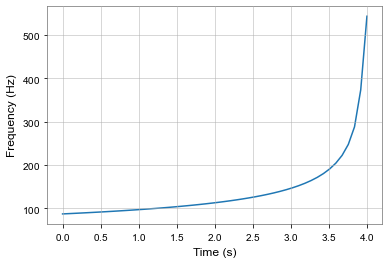

In [12]:
#----------------------------------------------------------------
# Frequency analytic
#----------------------------------------------------------------

def gwfreq(iM,iT,iT0):
    const = (948.5)*np.power((1./iM),5./8.)
    output = const*np.power(np.maximum((iT0-iT),3e-2),-3./8.) # we can max it out above 500 Hz-ish
    return output

times = np.linspace(0., 4., 50)
freq = gwfreq(20, times, 4)

plt.clf()
plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

The shape is very similar to what we have seen in data. You can use the model to fit data as play, and we don't do it here. Next, we try building the analytic model of wave form.

### Analytic model: Wave form
Now, we build the waveform with the radiation power $dE(t)/dt$.
\begin{eqnarray}
f(t) &= A(t)\cos(\omega(t)\Delta t +\phi) \\
\label{eq:ft}    &\propto \frac{dE(t)}{dt}\cos(\omega(t)\Delta t +\phi) \\
\end{eqnarray}
With Newtonian mechanics, we know the energy of a binary orbit is
\begin{eqnarray}
E &= E_{\mathrm{k}} + E_{\mathrm{u}} \\
    &= \frac{1}{2}\mu\dot{r}^{2} + \frac{1}{2}\frac{m_{1}m_{2}}{m_{1}+m_{2}}\omega^{2}R^{2} - \frac{Gm_{1}m_{2}}{R} \\
\label{eq:Etot}    &= \frac{1}{2}\frac{m_{1}m_{2}}{m_{1}+m_{2}}\omega^{2}R^{2} - \frac{Gm_{1}m_{2}}{R} \\ 
\end{eqnarray}
The last step is because $\dot{r} = 0$. According to Kepler's third law,
\begin{equation}\label{eq:kepler}
  \omega^{2} = \frac{G(m_{1}+m_{2})}{R^{3}}
\end{equation}
Put \eqref{eq:kepler} into \eqref{eq:Etot} and substitute $R$, we have
\begin{eqnarray}
E &= -\frac{Gm_{1}m_{2}}{2R} \\
\label{eq:Ew}    &\propto \mathcal{M}_{c}^{\frac{5}{3}}\omega(t)^{\frac{2}{3}} \\
\end{eqnarray}
Perform derivatives on Eq.\eqref{eq:Ew},
\begin{eqnarray}
\frac{dE}{dt} &\propto \mathcal{M}_{c}^{\frac{5}{3}}\omega(t)^{-\frac{1}{3}}\dot{\omega} \\
\label{eq:dEdt}    &\propto \left(\mathcal{M}_{c}\omega(t)\right)^{\frac{10}{3}} \\
\end{eqnarray}
Put Eq.\eqref{eq:dEdt} into Eq.~\eqref{eq:ft}, we have the waveform
\begin{eqnarray}
\label{eq:fwt}
f(t) &= C\left(\mathcal{M}_{c}\omega(t)\right)^{\frac{10}{3}}\cos(\omega(t)\Delta t +\phi), \\
    \mathrm{where}\:\omega(t) &= 948.5\left(\frac{M_{\odot}}{\mathcal{M}_{c}}\right)^{\frac{5}{8}}\left(\frac{1\:\mathrm{s}}{\Delta t}\right)^{\frac{3}{8}}\;\mathrm{[Hz\cdot rad]} \\
\end{eqnarray}
and $C$ is a constant. This waveform amplitude is only supposed to work before merger ($t \leq t_{0}$), and we need to come up with a way to define the ringdown amplitude ($t > t_{0}$). The actual way to get the amplitude requires months of a super computer to build good templates. As a simple approximate solution, you can use a simple damping function (Here I use an exponential).<br>
<span style="color:#CF7A17;font-weight:bold">What you need to do: Build a function osc(t, Mc, t0, C, phi). It has the form as Eq.\eqref{eq:fwt} for $t \leq t_{0}$, but damp to vanish for $t > t_{0}$.</span>

In [13]:
print('# [Hidden code]: Define the model function w(t) here.')
print('def osc(t, Mc, t0, C, phi):')

#----------------------------------------------------------------
# Wave form analytic
#----------------------------------------------------------------

def osc(t,Mc,t0,C,phi):
    freq = gwfreq(Mc,t,t0)
    val = C*(np.cos(freq*(t0-t)+phi))*1e-12
    val = val*np.power(Mc*freq,10./3.)*(1*(t<=t0)+np.exp((freq/(2*np.pi))*(t0-t))*(t>t0))
    return val

# [Hidden code]: Define the model function w(t) here.
def osc(t, Mc, t0, C, phi):


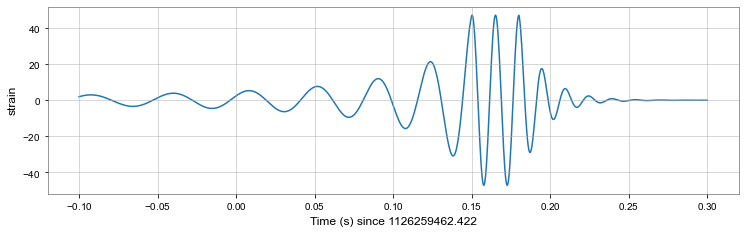

In [14]:
# Draw the function defined
times = np.linspace(-0.1, 0.3, 1000)
freq = osc(times, 30, 0.18, 1, 0.0)
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, freq)
plt.xlabel('Time (s) since '+str(tevent))
plt.ylabel('strain')
plt.show()

Looks not bad. Now we use this function to fit the data.

In [15]:
# define osc_dif for lmfit::minimize()
def osc_dif(params, x, data, eps):
    iM=params["Mc"]
    iT0=params["t0"]
    norm=params["C"]
    phi=params["phi"]
    val=osc(x, iM, iT0, norm, phi)
    return (val-data)/eps

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 1228
    # variables        = 4
    chi-square         = 0.72586206
    reduced chi-square = 5.9302e-04
    Akaike info crit   = -9120.38392
    Bayesian info crit = -9099.93135
[[Variables]]
    Mc:   17.3569276 +/- 0.20107011 (1.16%) (init = 20)
    t0:   0.18039070 +/- 5.8553e-04 (0.32%) (init = 0.18)
    C:   -0.04144573 +/- 0.00201508 (4.86%) (init = 1)
    phi: -2.09189725 +/- 0.37798441 (18.07%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) = -0.981
    C(Mc, phi) =  0.893
    C(Mc, t0)  = -0.825
    C(Mc, C)   =  0.253
    C(C, phi)  =  0.209
    C(t0, C)   = -0.188


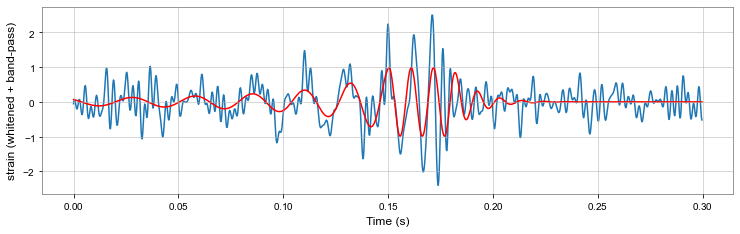

In [16]:
#----------------------------------------------------------------
# Fit
#----------------------------------------------------------------

sample_times = white_data_bp.times.value
sample_data = white_data_bp.value
indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(20)     # Mass guess
p['t0'].set(0.18)  # By construction we put the merger in the center
p['C'].set(1)      # normalization guess
p['phi'].set(0)    # Phase guess
unc = np.full(len(white_data_bp_zoom),20)
out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
plt.show()

With the simple analytic model, we actually caught the wave shape for $t<t_{0}$. The parameter gives the value $\mathcal{M}_{c}/M_{\odot}\sim 17$. The actual mass is $\sim 28$ (not too far!)

To get the actual form you need to do complicated numerical simulations. <br>
<span style="color:#CF7A17;font-weight:bold">What you need to do: load the template database, fit the data, and get more accurate parameters.</span>

## Search signal in long time range
When we zoom in the data above, we look at the small range where the signal is. However in reality we don't know where the signal is in advance.<br>
<span style="color:#CF7A17;font-weight:bold">What you need to do: develop a machinery to search for GW events across a long time range</span>.<br>
Tip: You can slice the time into short ranges, and fit by one and see the significance.

In [17]:
print('# [Hidden code]: develop a machinery to search for GW events across a long time range.')
#----------------------------------------------------------------
# Significance vs. time
#----------------------------------------------------------------

def fitrange(data,xx,tcenter,trange):
    findxt = np.where((xx >= tcenter-trange*0.5) & (xx < tcenter+trange*0.5))
    fwhite_data = data[findxt]
    x = xx[findxt]
    x = x-x[0]
    model = lmfit.Model(osc)
    p = model.make_params()
    p['Mc'].set(30)
    p['t0'].set(trange*0.5)
    p['C'].set(1)
    p['phi'].set(0)
    unc=np.full(len(fwhite_data),20)
    out = minimize(osc_dif, params=p, args=(x, fwhite_data, unc))
    return abs(out.params["C"].value/out.params["C"].stderr),out.redchi

times = np.arange(-14, 14, 0.05)
times += tevent
sigs=[]
chi2=[]
for time in times:
    pSig,pChi2 = fitrange(white_data_bp.value, sample_times, time, 0.4)
    sigs.append(pSig)
    chi2.append(pChi2)

# [Hidden code]: develop a machinery to search for GW events across a long time range.


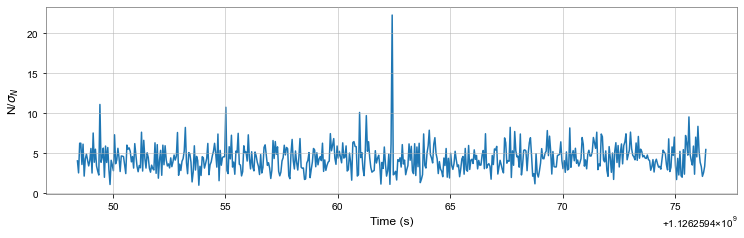

In [18]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, sigs)
plt.xlabel('Time (s)')
plt.ylabel('N/$\sigma_{N}$')
plt.show()

We can see the significance is significantly higher around the signal event. We can also check the $\chi^{2}$.

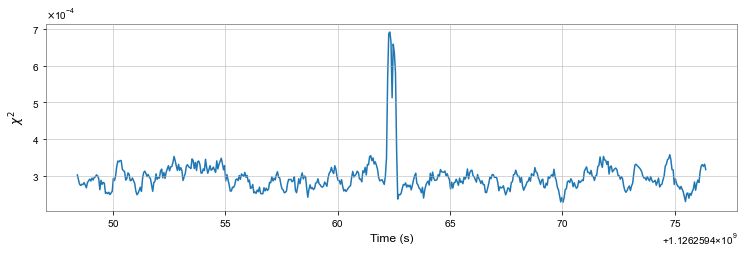

In [19]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, chi2)
plt.xlabel('Time (s)')
plt.ylabel('$\chi^{2}$')
plt.show()

## More things to explore
Now you have known the basic method to analyze a particular GW event. Now you can explore more interesting things.<br>
  * <span style="color:#CF7A17;font-weight:bold">Check and quantify the consistence between detectors (H1 and V1);</span>
  * <span style="color:#CF7A17;font-weight:bold">Load the template database, fit the data, and get more accurate parameters;</span>
  * <span style="color:#CF7A17;font-weight:bold">Determine how far the source of GW is away;</span>
  * <span style="color:#CF7A17;font-weight:bold">Explore more events;</span>
    * <span style="color:#CF7A17;font-weight:bold">Data of other events can be found [here](https://www.gw-openscience.org/eventapi/html/allevents/).</span>
  * <span style="color:#CF7A17;font-weight:bold">How to determine if the source is black hole merger or neutron star merger or other source?</span>

**Have fun!**